# Investigating the Boston House Prices Dataset

## Table of Contents <a class="ancor" id="contents"/>

1. [Introduction](#intro)
1. [Summary Statistics](#summary-stats)
1. [Visualising the Data](#plots)
    1. [Distribution of Price](#distPrice)
    1. [Correlation](#corr)
    1. [Scatter Plots of Relationships ](#scatter)
1. [CHAS Variable](#chas)
1. [Predicting the House Price](#pred)
    1. [Making a Model](#model)
    2. [Preparing the data](#prepare)
    3. [Building the Network](#network)
    4. [K-fold validation](#kfold)
1. [Conclusion](#conclusion)
1. [References](#refs)

## Introduction <a class="ancor" id="intro"/>

In this project, I will be looking at the well known Boston House Prices Dataset. It will include a look into the data and some general statistics, and then we will be attempting to use keras to create a neural network
that can predict the median house price based on the other variables in the dataset In this dataset information was collected from homes in suburbs of Boston, Massachusetts. This model could be very helpful for someone like a real estate agent city planners who could make use of such information on a daily basis.

The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts [5](#5)

## Summary Statistics <a class="ancor" id="summary-stats"/>

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import statsmodels.stats.weightstats as ws
import statsmodels.api as sm
import statsmodels.api as smapi
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from keras import models
from keras import layers


%matplotlib inline
plt.rcParams["figure.figsize"] = (15,7)

Next load data from scikit-learn library and have a look at data

In [86]:
boston = load_boston()
print(boston.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


These are essentially keys to a dictionary

- data: info for different houses
- target: prices for different houses
- feature_names: names of the features
- DESCR: describes the dataset

In [87]:
print(boston.data.shape)

(506, 13)


Check for its shape by calling the boston.data.shape and it will return the size of the dataset with the column size.
This means there are 506 rows of data with 13 columns.

In [88]:
print(boston.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


These are the column names but they don't make too much sense we need some more information

In [89]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

So as we can see there are quite a few variables listed that could have an effect on house prices such as crime rate, number of rooms, pupil teacher ratio.
***
So now we know a little more about this lets have a look using pandas at the actual data. To do this we have to convert it to dataframe and use head() to have a look

In [90]:
df = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
# add column names otherwise we just get index numbers which aren't very helpful alone
display(df.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


There seems to be no column called price in the dataframe. The target column is available in another attribute called target as we saw above when we looked at our keys. This is an important variable as later we will be trying to predict this. Our target is MEDV which is the median house value in 1000's of dollars.

In [91]:
print(boston.target.shape)
# rows see above data keys

(506,)


This number matches our datasets number of rows as we saw above so we can add it to our dataframe

In [92]:
# changed medv to price for readablity
df['PRICE'] = boston['target']
# used display to make nice table [1]
display(df.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [93]:
df.tail()
# zn and chas have alot of 0s - categorical?

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


In [94]:
df.isnull().sum()
#checking for any missing data 
#which Pandas automatically sets as NaN values.we can see these by using df.isnull() , 
#and then the number of NaN's per column is df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
PRICE      0
dtype: int64

In [95]:
len(df)

506

In [96]:
df.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
PRICE      float64
dtype: object

All data are floats, which means this is most likely a continuous variable, including the target. This means that predicting the target variable is a regression problem. [3](#3)

In [97]:
display(df.describe().T)
# transposed data to make it easier to read

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


We have data from 506 neighborhoods/townships in the Boston area. Summary of some tendencies and distribution of some key features:

- The average per capita crime rate is 3.61%
- The average number of rooms per dwelling is 6.28, but ranges from 3.5 to 8.7.
- The average nitric oxide concentration (in parts per 10 million) is .55. The neighborhood with the least NOX has .38, the one with the most has .87.
- The average Pupil-Teacher ratio is 18 students to one teacher.
- The average weighted distance to the five major Boston employment centers is 3.79.
- The average percent of lower status population is 12.65%, but ranges from 1.73% to a more impoverished 37.97%

In terms of price:
- The average price house was 22.532806	or \\$22,533
- The highest price was 50.0000 or \\$50,000
- The lowest price was 5.00000 or \\$5,000
- The standard deviation is 9.197104, which means our price values are quite widely spread

In [98]:
pricetotal = df.sort_values("PRICE", ascending = False)
pricetotal.head(20)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
283,0.01501,90.0,1.21,1.0,0.4010,7.923,24.8,5.8850,1.0,198.0,13.6,395.52,3.16,50.0
225,0.52693,0.0,6.20,0.0,0.5040,8.725,83.0,2.8944,8.0,307.0,17.4,382.00,4.63,50.0
369,5.66998,0.0,18.10,1.0,0.6310,6.683,96.8,1.3567,24.0,666.0,20.2,375.33,3.73,50.0
370,6.53876,0.0,18.10,1.0,0.6310,7.016,97.5,1.2024,24.0,666.0,20.2,392.05,2.96,50.0
371,9.23230,0.0,18.10,0.0,0.6310,6.216,100.0,1.1691,24.0,666.0,20.2,366.15,9.53,50.0
372,8.26725,0.0,18.10,1.0,0.6680,5.875,89.6,1.1296,24.0,666.0,20.2,347.88,8.88,50.0
186,0.05602,0.0,2.46,0.0,0.4880,7.831,53.6,3.1992,3.0,193.0,17.8,392.63,4.45,50.0
204,0.02009,95.0,2.68,0.0,0.4161,8.034,31.9,5.1180,4.0,224.0,14.7,390.55,2.88,50.0
257,0.61154,20.0,3.97,0.0,0.6470,8.704,86.9,1.8010,5.0,264.0,13.0,389.70,5.12,50.0
195,0.01381,80.0,0.46,0.0,0.4220,7.875,32.0,5.6484,4.0,255.0,14.4,394.23,2.97,50.0


Looking at the 20 highest priced homes, generally the crime rate seems to be lower. The houses mostly have more rooms, which makes sense as this would be a general trend from most houses. It also appears that the these homes tend to be in more affluent areas as the lsat of these homes is quite low. These homes also seem generally to be not beside the Charles River.

In [99]:
df[(df['AGE']>=95.0)].describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000
mean,9.102899,0.575221,17.778407,0.061947,0.663956,5.940398,98.222124,2.017613,15.132743,540.486726,19.153097,333.550177,19.131770,17.471681
std,12.444375,3.098258,4.656246,0.242133,0.093453,0.707281,1.699461,0.882386,9.836616,157.596689,2.340523,107.242503,7.703658,9.793169
min,0.098490,0.000000,2.460000,0.000000,0.448000,3.863000,95.000000,1.137000,2.000000,188.000000,13.000000,2.600000,1.920000,5.000000
25%,1.192940,0.000000,18.100000,0.000000,0.605000,5.520000,96.800000,1.527500,5.000000,403.000000,19.100000,330.040000,15.020000,12.300000
50%,5.872050,0.000000,18.100000,0.000000,0.659000,6.006000,98.300000,1.812500,24.000000,666.000000,20.200000,380.790000,18.850000,15.000000
75%,11.951100,0.000000,19.580000,0.000000,0.700000,6.402000,100.000000,2.118500,24.000000,666.000000,20.200000,396.900000,24.080000,19.100000
max,73.534100,20.000000,27.740000,1.000000,0.871000,7.929000,100.000000,6.082100,24.000000,711.000000,21.200000,396.900000,37.970000,50.000000


Here we are looking at the older neighbourhoods in the dataset, these houses are falling below the average, with an average price of \\$17,472. This is to be expected as you would expect an older house to cost less.

In [100]:
df[(df['INDUS']>=15.0)].describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,9.157806,0.437500,19.105833,0.078125,0.672026,6.021161,90.736458,2.036530,17.833333,584.572917,19.344792,307.182135,17.739271,17.706771
std,12.069641,3.481627,2.263625,0.269070,0.086411,0.702431,12.360731,0.581004,9.185883,138.590794,2.049894,130.480605,7.211651,8.997196
min,0.028750,0.000000,15.040000,0.000000,0.464000,3.561000,28.900000,1.129600,2.000000,188.000000,14.700000,0.320000,1.730000,5.000000
25%,2.310525,0.000000,18.100000,0.000000,0.605000,5.690500,87.975000,1.612875,5.000000,437.000000,20.200000,292.105000,13.317500,12.700000
50%,5.776155,0.000000,18.100000,0.000000,0.671000,6.107500,95.250000,1.931050,24.000000,666.000000,20.200000,375.005000,17.155000,15.900000
75%,11.121175,0.000000,19.580000,0.000000,0.713000,6.402500,98.425000,2.307925,24.000000,666.000000,20.200000,395.017500,22.267500,20.600000
max,88.976200,28.000000,27.740000,1.000000,0.871000,8.780000,100.000000,4.098300,24.000000,711.000000,21.200000,396.900000,37.970000,50.000000


As expected homes that that have more non-retail business acres per town (ie these would be heavy industry areas) have a lower mean house price of \\$17,707.

## Visualising the Data <a class="ancor" id="plots"/>
### Distribution of Price <a class="ancor" id="distPrice"/>

Text(0.5, 1.0, 'Distrubution of Price')

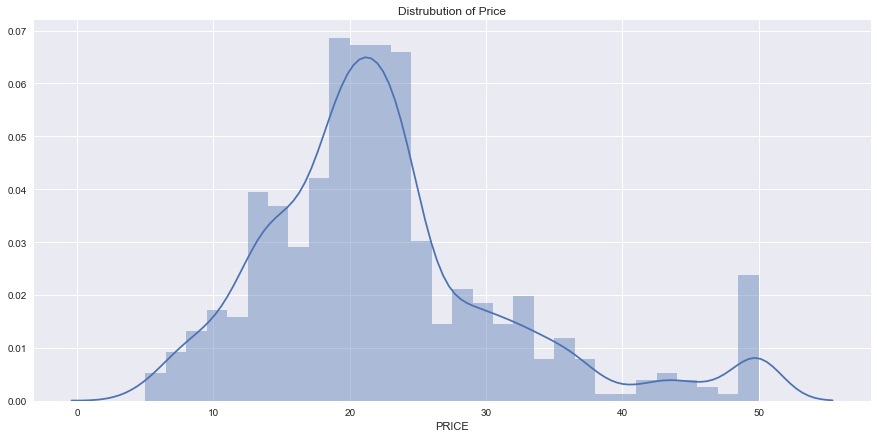

In [101]:
sns.distplot(df["PRICE"], bins=30)
plt.title("Distrubution of Price")

We see that the values of price are distributed normally with few outliers. There are a lot of values at the 50 point, perhaps the data is capped at 50 ie if a house was priced over 50 then it was just entered at that number.

### Correlations <a class="ancor" id="corr"/>

In [102]:
correlation = df.corr().round(2)
display(correlation)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
CRIM,1.00,-0.20,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39
ZN,-0.20,1.00,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36
INDUS,0.41,-0.53,1.00,0.06,0.76,-0.39,0.64,-0.71,0.60,0.72,0.38,-0.36,0.60,-0.48
CHAS,-0.06,-0.04,0.06,1.00,0.09,0.09,0.09,-0.10,-0.01,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,0.09,1.00,-0.30,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43
RM,-0.22,0.31,-0.39,0.09,-0.30,1.00,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.70
AGE,0.35,-0.57,0.64,0.09,0.73,-0.24,1.00,-0.75,0.46,0.51,0.26,-0.27,0.60,-0.38
DIS,-0.38,0.66,-0.71,-0.10,-0.77,0.21,-0.75,1.00,-0.49,-0.53,-0.23,0.29,-0.50,0.25
RAD,0.63,-0.31,0.60,-0.01,0.61,-0.21,0.46,-0.49,1.00,0.91,0.46,-0.44,0.49,-0.38
TAX,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1.00,0.46,-0.44,0.54,-0.47


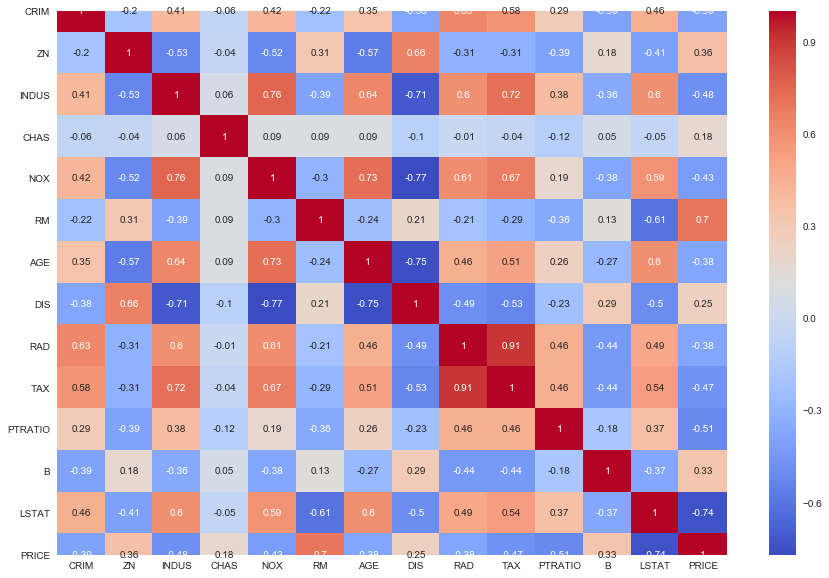

In [103]:
plt.figure(figsize=(15,10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Looking at our correlations, RM and LSTAT seem to be the biggest predictors of price. Median value of owner-occupied homes (in 1000$) increases as average number of rooms per dwelling increases and it decreases if percent of lower status population in the area increases. This mirrors the trend noticed earlier in the top 20 priced houses from earlier. PTRATIO, TAX, NOX, INDUS and CRIM are also appearing as weaker but still significant predictors. CHAS does not seem to be a significant predictor of PRICE.

Other things of note are:
- nox or nitrogen oxides concentration (ppm) increases with increase in proportion of non-retail business acres per town and proportion of owner-occupied units built prior to 1940.
- rad and tax have a strong positive correlation of 0.91 which implies that as accessibility of radial highways increases, the full value property-tax rate per $10,000 also increases.
- crim is strongly associated with variables rad and tax which implies as accessibility to radial highways increases, per capita crime rate increases.
- indus has strong positive correlation with nox, which supports the notion that nitrogen oxides concentration is high in industrial areas.

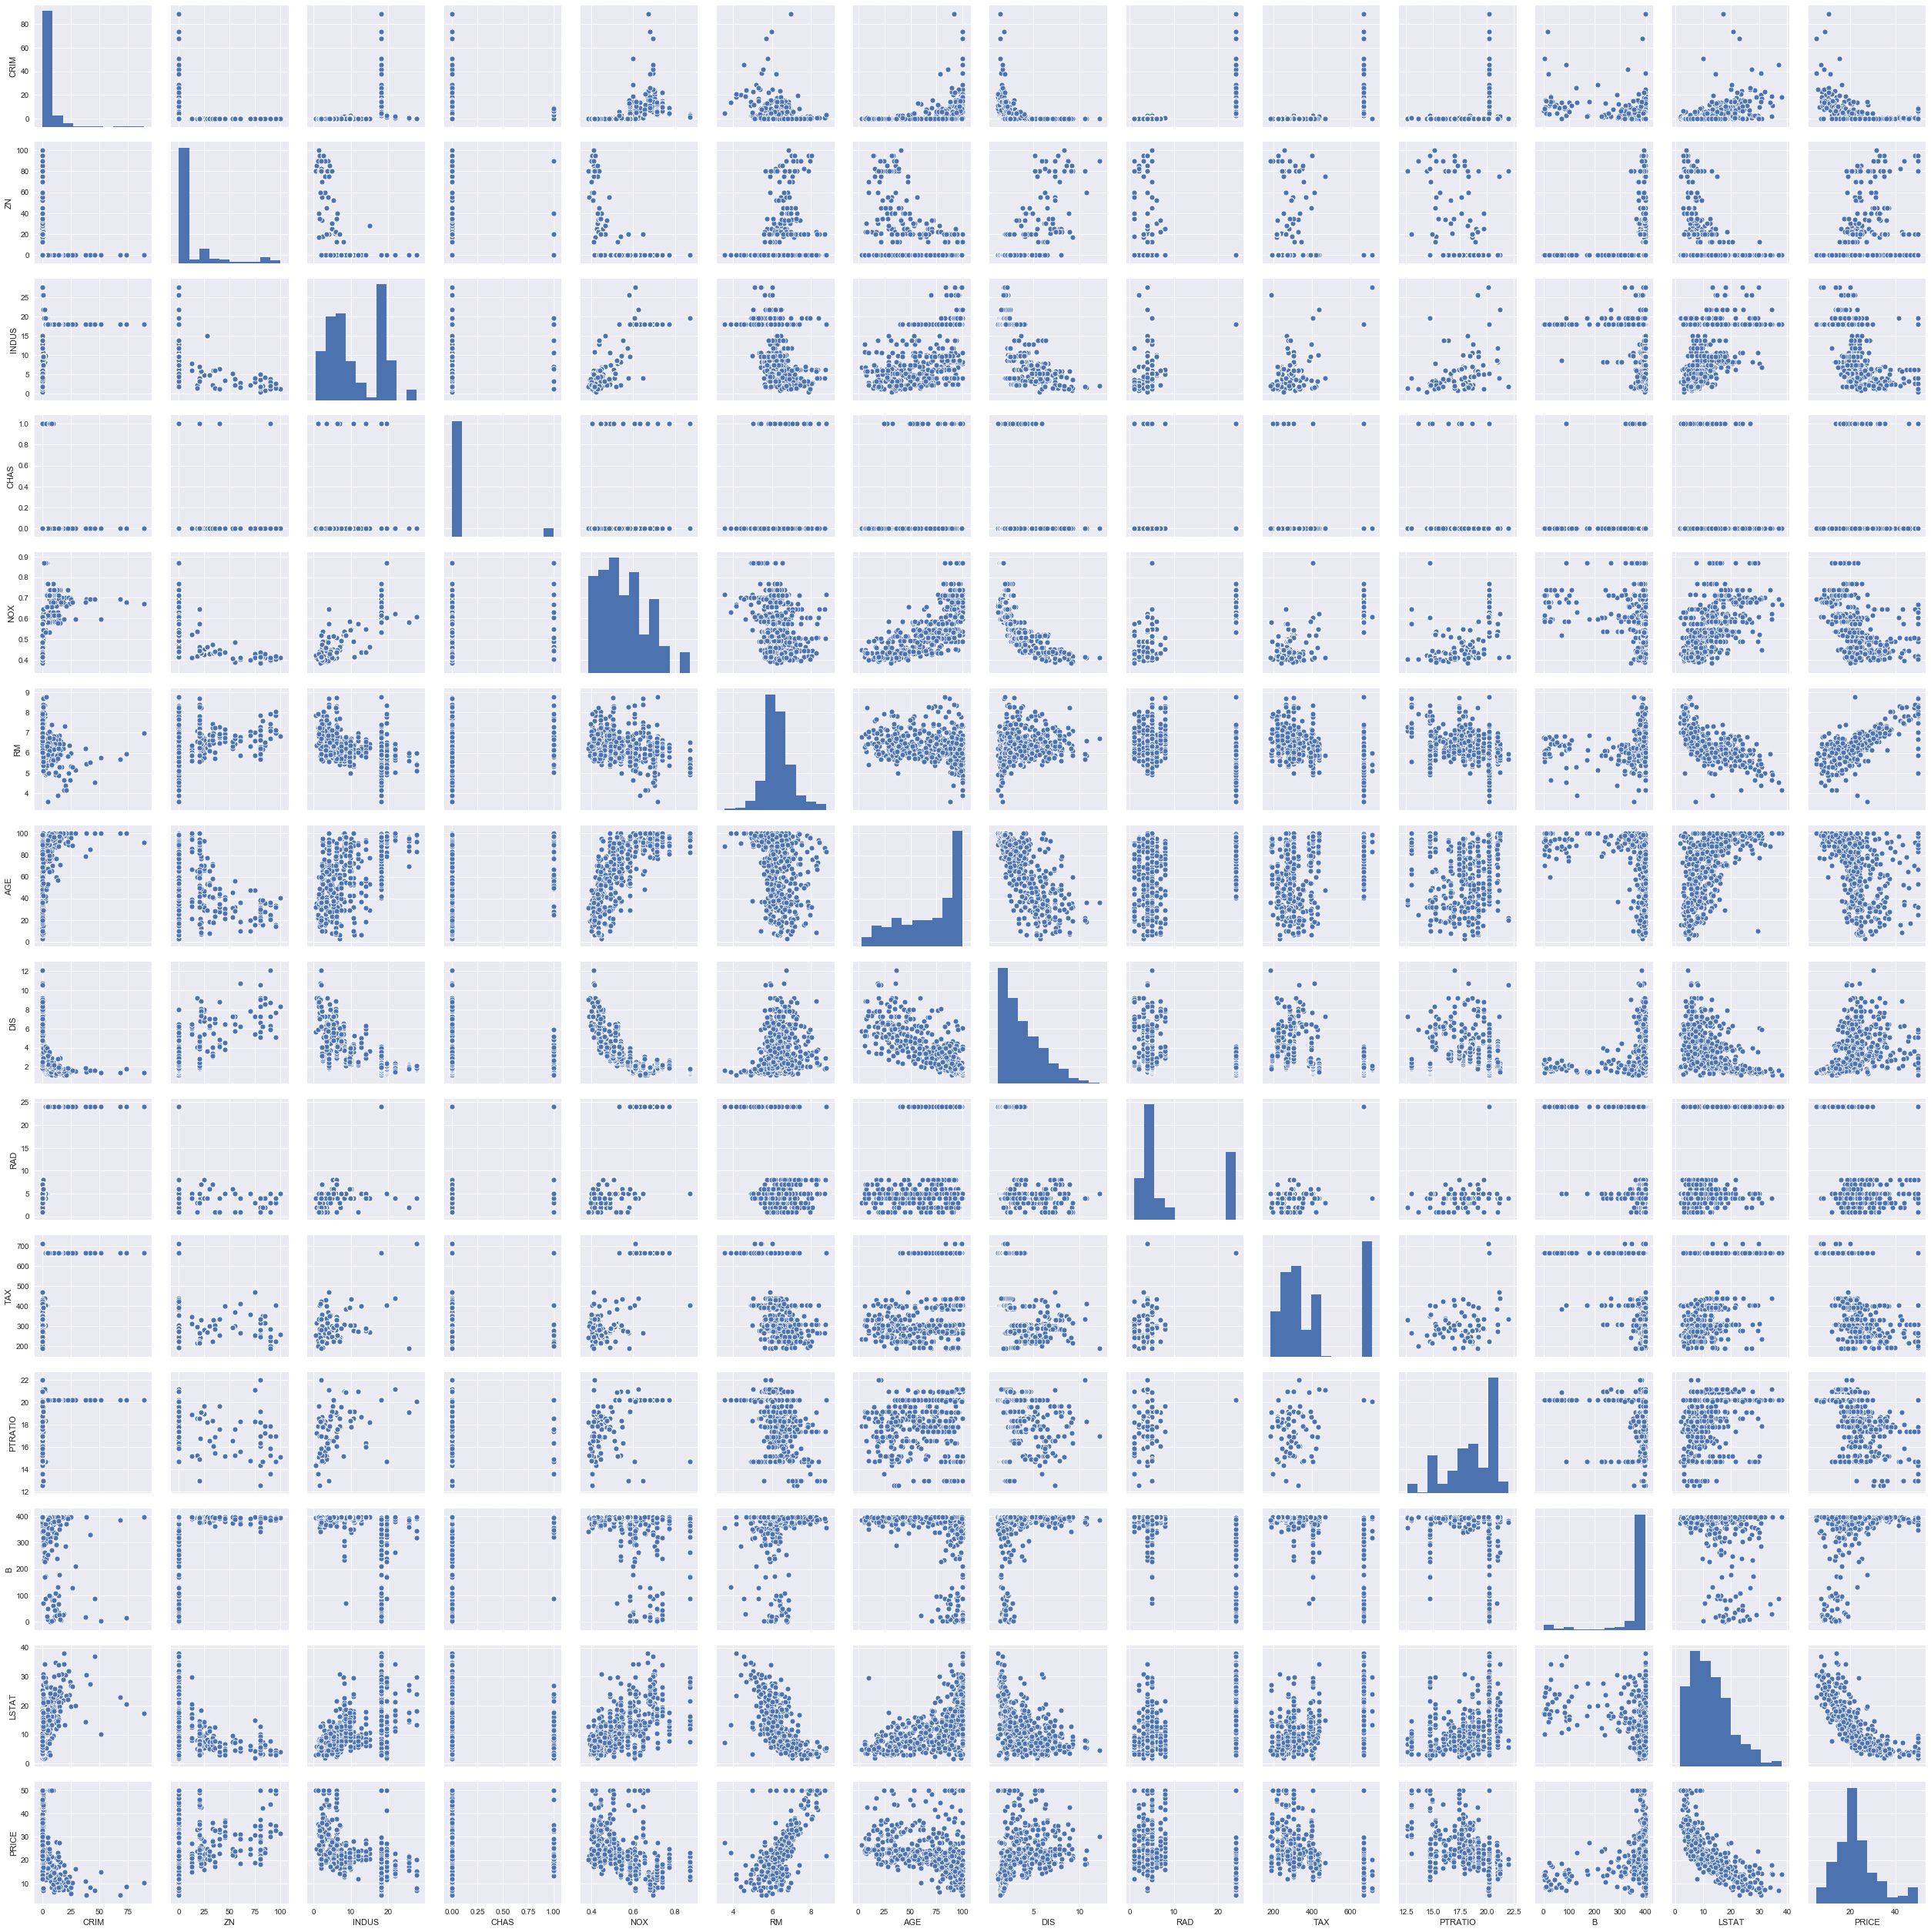

In [104]:
sns.pairplot(df)

- The Proportion of owner occupied units built prior to 1940 (AGE) and proportion of black people by town (B) is heavily skewed to right
- Crime rate (CRIM) and weighted mean of distances to five Boston employment centres (DIS) is heavily skewed to left. 
- RM is normally distributed with mean of approximately 6.
- Most of the properties are situated close to the employment centres (DIS skewed to left) 
- There is a high proportion of owner occupied units built prior to 1940 (age skewed to right) and black people in town (black skewed to right) 
- From scatter plots, it is seen that LSTAT and RM show strong correlation with PRICE. 
- 93% of the properties are away from Charles river. The properties bordering the river seems to have higher median prices.

### Scatter Plots of Relationships <a class="ancor" id="scatter"/>

Stronger predictors will have small, tight distributions of data around the line of best fit estimated by the plot.

Text(0.5, 1.0, 'Relationship between RM and Price')

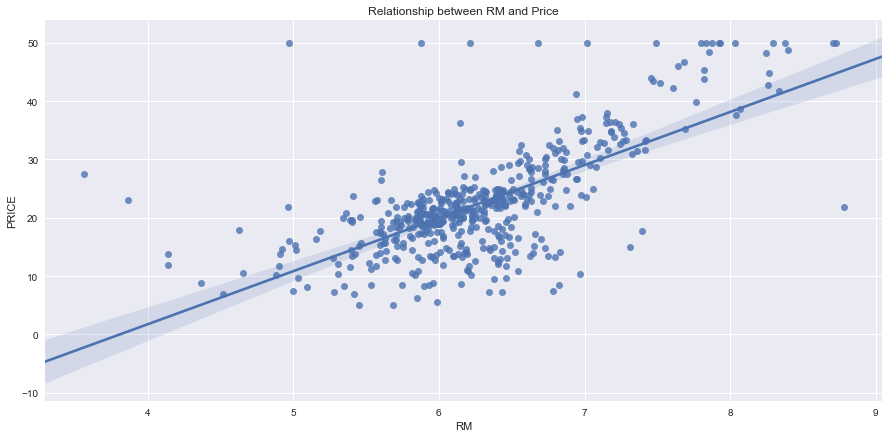

In [105]:
sns.regplot(y="PRICE", x="RM", data=df, fit_reg = True)
plt.title("Relationship between RM and Price")

The number of rooms looks to have strong positive correlation - the prices increase as the value of RM increases linearly. This makes sense as we mentioned earlier, the more rooms a home has, the higher the price will be. There are few outliers and the data seems to be capped at 50 as observed earlier.

Text(0.5, 1.0, 'Relationship between LSTAT and Price')

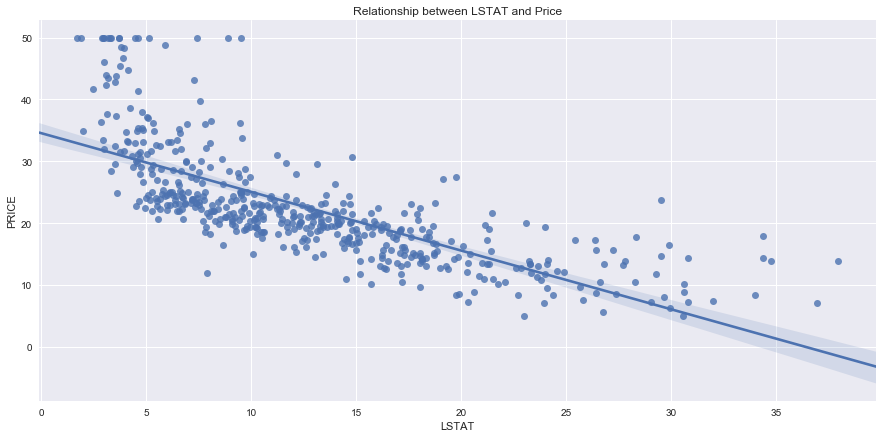

In [106]:
sns.regplot(y="PRICE", x="LSTAT", data=df, fit_reg = True)
plt.title("Relationship between LSTAT and Price")

The percentage of lower status population seems to have a strong negative correlation. The prices tend to decrease with an increase in lower status individuals. The is a trend we noticed earlier in the statistics, and it would be a reasonable expectation that the lower economic status of the area, the lower the house price.  However it it does not look to be following an exactly linear line.

Text(0.5, 1.0, 'Relationship between PTRATIO and Price')

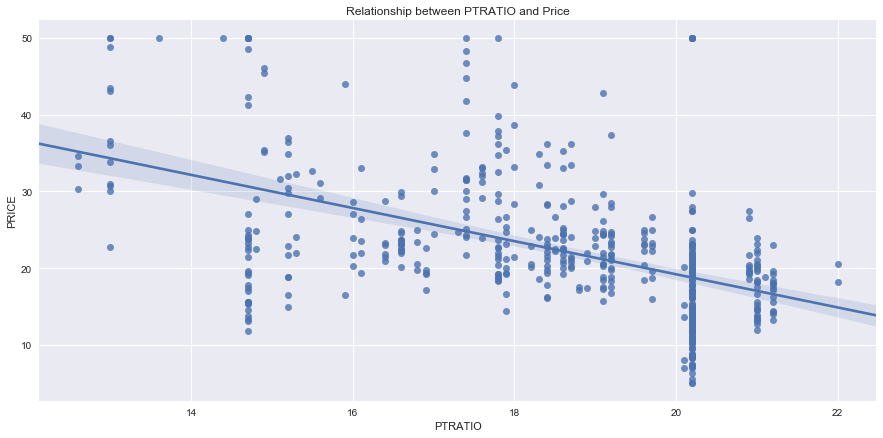

In [107]:
sns.regplot(y="PRICE", x="PTRATIO", data=df, fit_reg = True)
plt.title("Relationship between PTRATIO and Price")

The Pupil Teacher Ratio - as the number of students increases for every teacher, the value of housing decreases.

Text(0.5, 1.0, 'Relationship between NOX and Price')

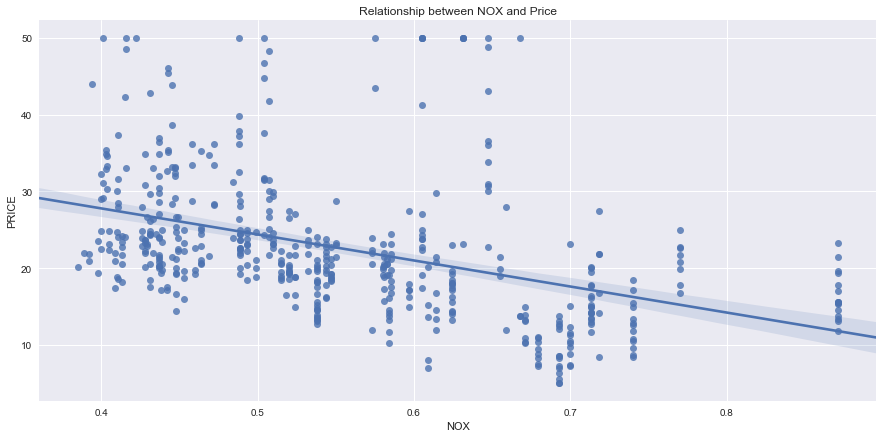

In [108]:
sns.regplot(y="PRICE", x="NOX", data=df, fit_reg = True)
plt.title("Relationship between NOX and Price")

The Nitrus Oxide Concentration (in parts per 10 million) has strong negative coorelation - prices seems to decrease the more pollution there is. Again this makes sense and is in line with what would be expected to be a factor in house prices, especially considering when the dataset was gathered, air pollution from factories would have been a big topic in the general public.

Text(0.5, 1.0, 'Relationship between DIS and Price')

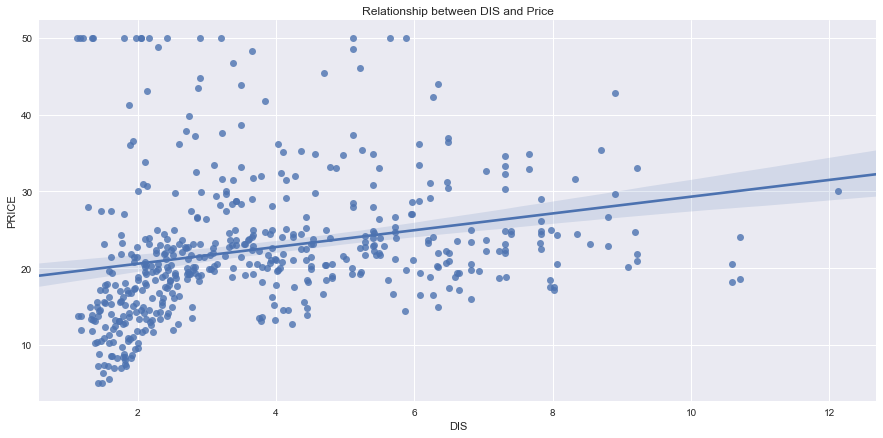

In [109]:
sns.regplot(y="PRICE", x="DIS", data=df, fit_reg = True)
plt.title("Relationship between DIS and Price")

The Weighted Distance from 5 Major Employment Center - there is a strong positive correlation. The closer the burrogh is to employment centers, the higher the housing price.

Text(0.5, 1.0, 'Relationship between Tax Rate and Price')

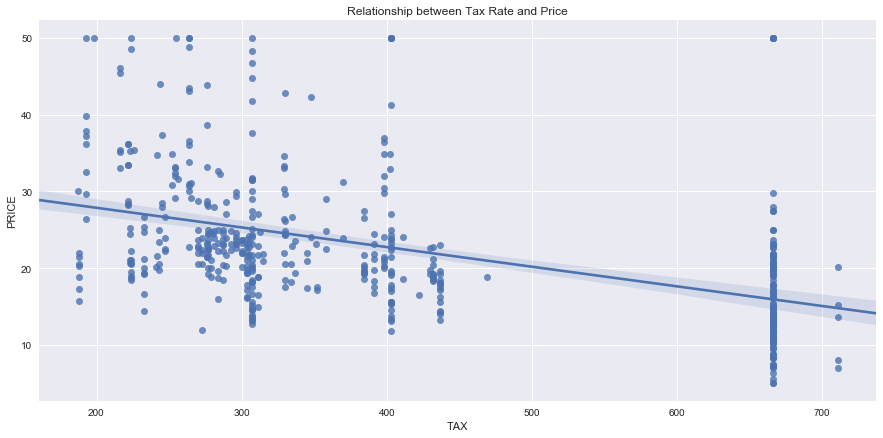

In [110]:
sns.regplot(y="PRICE", x="TAX", data=df, fit_reg = True)
plt.title("Relationship between Tax Rate and Price")

As the tax rate increases the property price decreases, again this is not too surprising of an outcome as a house with a lower tax rate per 10,000 would be more desirable.

Text(0.5, 1.0, 'Relationship between Industry and Price')

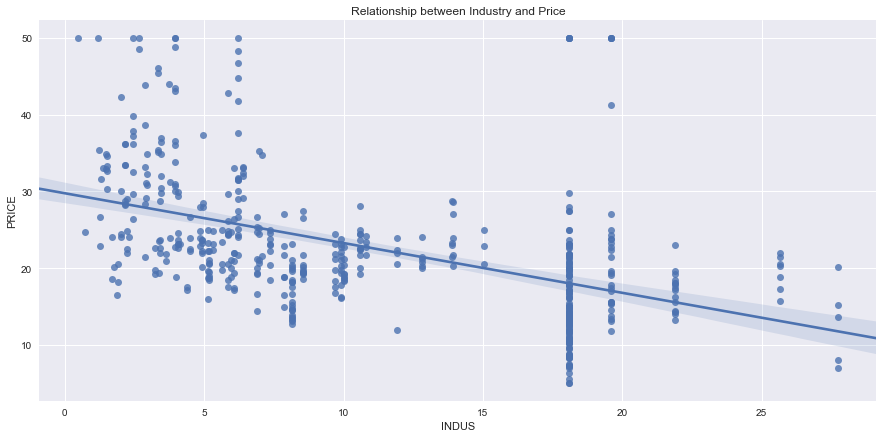

In [111]:
sns.regplot(y="PRICE", x="INDUS", data=df, fit_reg = True)
plt.title("Relationship between Industry and Price")

As the amount of industry increases, the house prices tend to decrease. People generally tend not to like to live too close to alot of factories (also tying into the pollution mentioned above) so this could be a reason for the decrease.

Text(0.5, 1.0, 'Relationship between Crime Rate and Price')

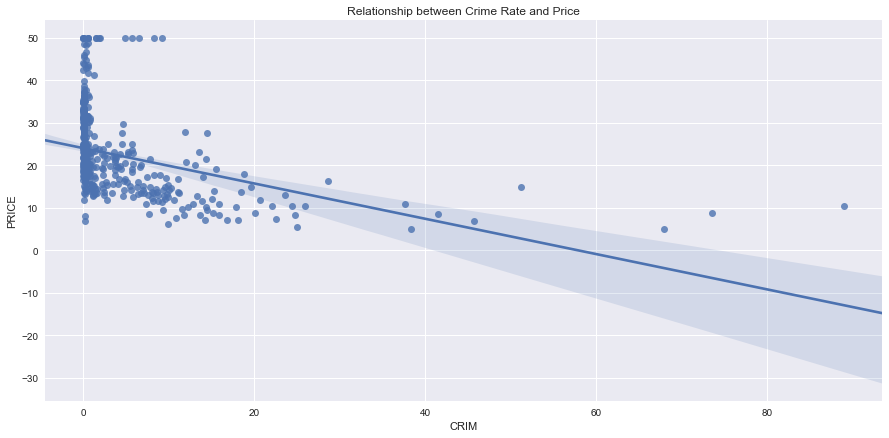

In [112]:
sns.regplot(y="PRICE", x="CRIM", data=df, fit_reg = True)
plt.title("Relationship between Crime Rate and Price")

As the crime rate decreases/increases, the housing price increases/decreases. However the data is very heavily skewed due to a few outliers.

## CHAS variable <a class="ancor" id="chas"/>

In the dataset, there is a variable named CHAS that track whether a house is beside the Charles River or not. An input of 1 means that it **is** beside the river, and 0 means that it is **not** beside the River

In [113]:
df.CHAS
df["CHAS"].value_counts()

0.0    471
1.0     35
Name: CHAS, dtype: int64

There are 35 homes beside the Charles River and 471 that are not beside the river.

In [114]:
df.pivot(columns='CHAS', values='PRICE').describe()

CHAS,0.0,1.0
count,471.000000,35.000000
mean,22.093843,28.440000
std,8.831362,11.816643
min,5.000000,13.400000
25%,16.600000,21.100000
50%,20.900000,23.300000
75%,24.800000,33.150000
max,50.000000,50.000000


So there is a difference in the average house prices with houses beside the river costing \\$28,440. The average price of a house not beside the river is \\$22,094. The houses beside the river seem to be widely spread throughout the dataset (std of 11.82).

In [115]:
df.pivot(columns='CHAS', values='CRIM').describe()

CHAS,0.0,1.0
count,471.000000,35.000000
mean,3.744447,1.851670
std,8.876818,2.494072
min,0.006320,0.015010
25%,0.079640,0.125060
50%,0.245220,0.447910
75%,3.695030,3.397665
max,88.976200,8.982960


Houses that were beside the river have a lower average crime rate (1.9%) than those that were not beside the river (3.7%).

In [116]:
df.pivot(columns='CHAS', values='LSTAT').describe()

CHAS,0.0,1.0
count,471.000000,35.000000
mean,12.757941,11.241714
std,7.169271,6.686651
min,1.730000,1.920000
25%,7.160000,5.395000
50%,11.380000,10.500000
75%,17.095000,15.070000
max,37.970000,26.820000


There is a small difference in the average percentage of lower status population - 11.2% for those beside the river, and 12.8% for those not beside the river.

In [117]:
print(df.CHAS[df['PRICE']==50.0])
df.CHAS[df['PRICE']==50.0].count()

161    0.0
162    1.0
163    1.0
166    0.0
186    0.0
195    0.0
204    0.0
225    0.0
257    0.0
267    0.0
283    1.0
368    0.0
369    1.0
370    1.0
371    0.0
372    1.0
Name: CHAS, dtype: float64


16

Just over 30% of the \\$50000 average house prices are beside the river.

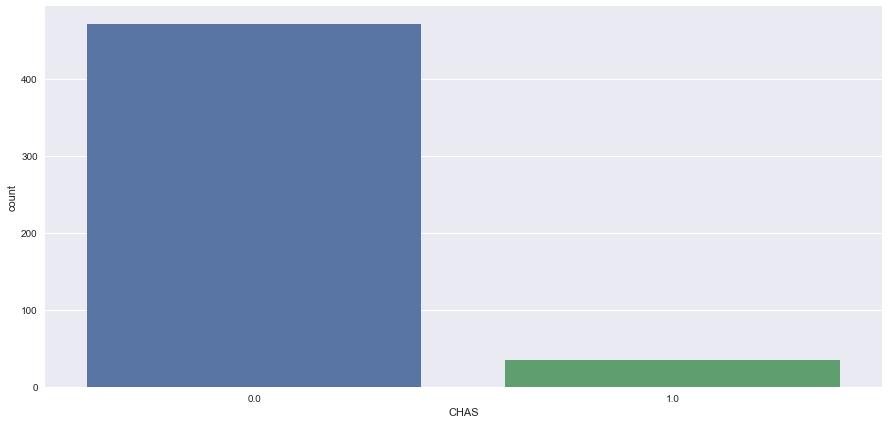

In [118]:
sns.countplot(x='CHAS', data=df)

As we noted earlier, there are a lot more houses not on the river, than are on the river.

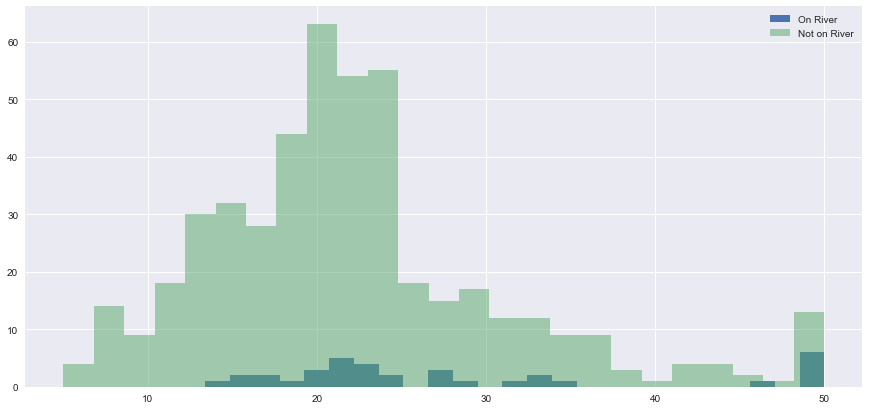

In [119]:
[7]
RiverH = df[df['CHAS'] == 1.0]['PRICE']
NRiverH = df[df['CHAS'] == 0.0]['PRICE']

plt.style.use('seaborn-deep')
plt.hist(RiverH, bins=25, label='On River')
plt.hist(NRiverH, bins= 25, alpha=0.5, label='Not on River')

plt.legend()
plt.show()

The houses along the river are very scattered through the dataset and a lot of the 50 and above priced properties are beside the river as we noted earlier.

Text(0.5, 1.0, 'Price vs Room by River Variable')

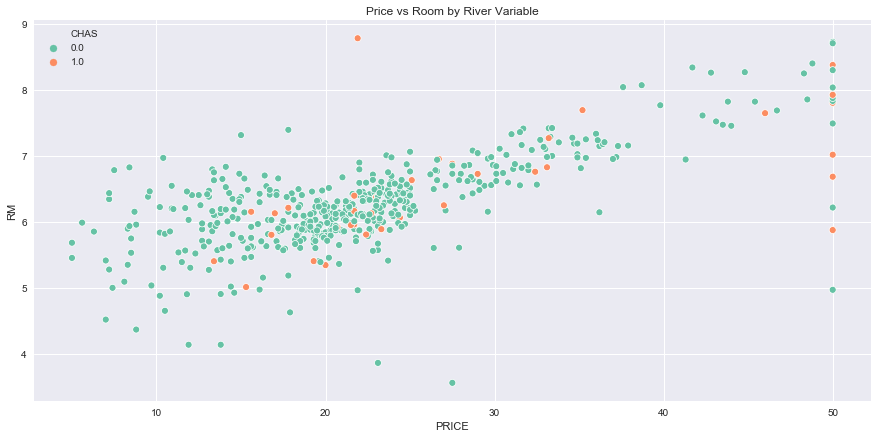

In [120]:
sns.set_palette("Set2")
sns.scatterplot(data=df,x='PRICE',y='RM', hue='CHAS')
plt.title("Price vs Room by River Variable")

Text(0.5, 1.0, 'Price vs Socio Economic Status of Area by River Variable')

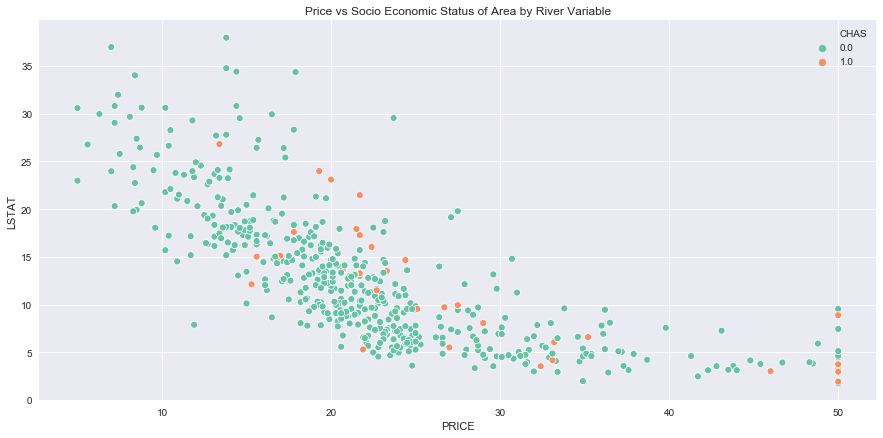

In [121]:
sns.scatterplot(data=df,x='PRICE',y='LSTAT', hue='CHAS')
plt.title("Price vs Socio Economic Status of Area by River Variable")

As we noted in the earlier, there does not seem to be any meaningful relationship between CHAS and PRICE. We would probably need more information or samples to detect any trends in this variable

In [122]:
ws.ttest_ind(RiverH, NRiverH)

(3.9964374660905095, 7.390623170519883e-05, 504.0)

The t test is a measurement of whether the average (expected) value will differ significantly across the samples provided. A large p-value (greater than 0.05 or 0.1) then we cannot reject the null hypothesis. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages [6](#6)

The t-test gives a very small p-value significantly below 1%, so we we have a clear statistically significant difference and we therefore have to reject the null hypothesis.

In [123]:
stats.f_oneway(RiverH, NRiverH)

F_onewayResult(statistic=15.971512420371962, pvalue=7.390623170520815e-05)

An ANOVA test is a little more robust that a simple t-test so looking at the results, our F-statistic of 15.97 suggests the between-groups variance is nearly 16x the within-group variance. Now we know the ratio of our variances doesn’t equal one, and the null hypothesis of equal mean values is rejected due to the p value being less than 0.05 as we noted above [9](#9)

In [124]:
# Fitting the model using just chas variable
model = ols("PRICE ~ C(CHAS)", data=df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     15.97
Date:                Thu, 14 Nov 2019   Prob (F-statistic):           7.39e-05
Time:                        23:02:03   Log-Likelihood:                -1832.3
No. Observations:                 506   AIC:                             3669.
Df Residuals:                     504   BIC:                             3677.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         22.0938      0.418     52.902      0.000      21.273      22.914
C(CHAS)[T.1.0]     6.3462      1.588      3.996      0.000       3.226       9.466
==============================================================================
Omnibus:                       81.923   Durbin-Watson:                   0.579
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.534
Skew:                           1.043   Prob(JB):                     5.50e-28
Kurtosis:                       4.267   Cond. No.                         3.96
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Once we have the model we need to evaluate it’s fit. We will evaluate the overall fit of a linear model, using the R-squared value
R-Squared:
- R-squared is the proportion of variance explained
- It is the proportion of variance in the observed data that is explained by the model, or the reduction in error over the null model
- The null model just predicts the mean of the observed response, and thus it has an intercept and no slope
- R-squared is between 0 and 1
- Higher values are better because it means that more variance is explained by the model.

0.031 is the R-squared value when means this is not a great fit

In [125]:
# looking at the older negihbourhoods
df['OLD'] = df.AGE >=95.0
df.OLD.describe()

count       506
unique        2
top       False
freq        393
Name: OLD, dtype: object

In [126]:
# looking at the more industry heavy areas
df['NORETAIL'] = df.INDUS >=15.0
df.NORETAIL.describe()

count       506
unique        2
top       False
freq        314
Name: NORETAIL, dtype: object

In [127]:
print(df.groupby(["OLD","CHAS"])["PRICE"].count())

OLD    CHAS
False  0.0     365
       1.0      28
True   0.0     106
       1.0       7
Name: PRICE, dtype: int64


Only 6.6% of the older neighbourhoods (from pre 1940s) were beside the river. This means that the buildings along the river seem to be generally newer.

In [128]:
print(df.groupby(["NORETAIL","CHAS"])["PRICE"].count())

NORETAIL  CHAS
False     0.0     294
          1.0      20
True      0.0     177
          1.0      15
Name: PRICE, dtype: int64


Only 8.5% of the houses that have a high proportion of non retail land were also beside the river so there seems to be less industry around the river.

In [129]:
model = ols("PRICE ~ C(CHAS)*C(OLD) + C(CHAS) + C(OLD)", data=df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     25.02
Date:                Thu, 14 Nov 2019   Prob (F-statistic):           4.24e-15
Time:                        23:02:03   Log-Likelihood:                -1805.0
No. Observations:                 506   AIC:                             3618.
Df Residuals:                     502   BIC:                             3635.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        23.6989      0.450     52.624      0.000      22.814      24.584
C(CHAS)[T.1.0]                    4.0582      1.687      2.405      0.017       0.743       7.373
C(OLD)[T.True]                   -7.1319      0.949     -7.513      0.000      -8.997      -5.267
C(CHAS)[T.1.0]:C(OLD)[T.True]    10.5462      3.758      2.807      0.005       3.164      17.929
==============================================================================
Omnibus:                      115.392   Durbin-Watson:                   0.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              227.829
Skew:                           1.257   Prob(JB):                     3.37e-50
Kurtosis:                       5.118   Cond. No.                         10.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Including the interaction between the older houses, this model is giving the best p value for CHAS (0.017). So the model is price = 23.6989 + 4.0582 x chas - 7.1319 x old x chas x old. The R-squared value is 0.130 which is a little but, but still not great.

So this is telling us from the base price of \\$23,699, you gain \\$4,058 to the value if the house is beside the river. You lose $7,132 if the house is in a neighborhood with a lot of houses built before 1940. If a home is beside the river and in a neighbourhood with a lot of older houses then it will gain \\$10,546 (old money maybe?)

But as with the previous model even though the coefficients are significantly different from 0, the model does not explain enough about the differences in the price.

## Predicting the House Price <a class="ancor" id="pred"/>

### Making a Model <a class="ancor" id="model"/>

In [130]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE,OLD,NORETAIL
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,False,False
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,False,False
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,False,False
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4,False,False
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2,False,False


In [131]:
# dropping columns we made earlier
df = df.drop("OLD", 1)

In [132]:
df = df.drop("NORETAIL", 1)

So in our analysis earlier, nearly all of the variables displayed some sort of linear relationship with price. Some were stronger than others, however we will fit all of them in this model as the more information we can give our neural network the better. We do need to be aware of overfitting also, however this dataset is really small so it will probably be an issue we need to be aware of [18](#18)

In [133]:
model = ols("PRICE ~ CRIM + INDUS + C(CHAS) + NOX + RM + DIS + RAD + TAX + PTRATIO + LSTAT + B + ZN + AGE", data=df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Thu, 14 Nov 2019   Prob (F-statistic):          6.72e-135
Time:                        23:02:04   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         36.4595      5.103      7.144      0.000      26.432      46.487
C(CHAS)[T.1.0]     2.6867      0.862      3.118      0.002       0.994       4.380
CRIM              -0.1080      0.033     -3.287      0.001      -0.173      -0.043
INDUS              0.0206      0.061      0.334      0.738      -0.100       0.141
NOX              -17.7666      3.820     -4.651      0.000     -25.272     -10.262
RM                 3.8099      0.418      9.116      0.000       2.989       4.631
DIS               -1.4756      0.199     -7.398      0.000      -1.867      -1.084
RAD                0.3060      0.066      4.613      0.000       0.176       0.436
TAX               -0.0123      0.004     -3.280      0.001      -0.020      -0.005
PTRATIO           -0.9527      0.131     -7.283      0.000      -1.210      -0.696
LSTAT             -0.5248      0.051    -10.347      0.000      -0.624      -0.425
B                  0.0093      0.003      3.467      0.001       0.004       0.015
ZN                 0.0464      0.014      3.382      0.001       0.019       0.073
AGE                0.0007      0.013      0.052      0.958      -0.025       0.027
==============================================================================
Omnibus:                      178.041   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.126
Skew:                           1.521   Prob(JB):                    8.84e-171
Kurtosis:                       8.281   Cond. No.                     1.51e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

So our model is looking like:

$$HouseValue = 34.7 + 0.7900(BesideRiver) - 0.1130(CrimeRate) - 0.0345(%ofIndustryAcres) - 12.9800(NoxLevels) + 3.4017(Rooms) - 1.2408(DistanceEmploymentCentre) + 0.2761(HighwayAccess) - 0.0134(HigherTaxRates) - 0.8276(PupilTeacherRatio) -0.4315(%lowerSocioEconomicPopulation) + 0.0078(%BlackPeople) + 0.0380(%ResidentialLand) - -0.0150(%OlderBuildings)$$

Intuitively, all of this makes sense as we observed earlier, the house value should be expected to go down if the crime rate of an area is high, etc.

The prediction fit may look good, but if we had to compare many models and determine the best one, it may be difficult. Therefore, the coefficient of determination (R²) is used to give a numerical value of the fit. The R² value for the model above is 0.760, which is great considering we only applied linear regression!

One thing to keep in mind is that our model had 13 different features. By increasing the amount of features (i.e., by providing our model with more information), we can always increase the R² value. But this may not be a good thing because it may lead to overfitting. To account for this phenomenon, there is a second way to evaluate our model called R² adjusted. This measure normalizes the R² by the amount of features. If we have 100 features, the R² value will be much higher than 0.760 because of the extra information, but the R² adjusted penalizes the fit by having additional features. For this fitted model, the R² adjusted value is 0.754 only slightly lower than the R² [18](#18)

Lets try to improve the R²  value. In the above model, age and indus have high p values so let's remove them.

In [134]:
model = ols("PRICE ~ CRIM + C(CHAS) + NOX + RM + DIS + RAD + TAX + PTRATIO + LSTAT + B + ZN", data=df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     128.2
Date:                Thu, 14 Nov 2019   Prob (F-statistic):          5.54e-137
Time:                        23:02:04   Log-Likelihood:                -1498.9
No. Observations:                 506   AIC:                             3022.
Df Residuals:                     494   BIC:                             3072.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         36.3411      5.067      7.171      0.000      26.385      46.298
C(CHAS)[T.1.0]     2.7187      0.854      3.183      0.002       1.040       4.397
CRIM              -0.1084      0.033     -3.307      0.001      -0.173      -0.044
NOX              -17.3760      3.535     -4.915      0.000     -24.322     -10.430
RM                 3.8016      0.406      9.356      0.000       3.003       4.600
DIS               -1.4927      0.186     -8.037      0.000      -1.858      -1.128
RAD                0.2996      0.063      4.726      0.000       0.175       0.424
TAX               -0.0118      0.003     -3.493      0.001      -0.018      -0.005
PTRATIO           -0.9465      0.129     -7.334      0.000      -1.200      -0.693
LSTAT             -0.5226      0.047    -11.019      0.000      -0.616      -0.429
B                  0.0093      0.003      3.475      0.001       0.004       0.015
ZN                 0.0458      0.014      3.390      0.001       0.019       0.072
==============================================================================
Omnibus:                      178.430   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              787.785
Skew:                           1.523   Prob(JB):                    8.60e-172
Kurtosis:                       8.300   Cond. No.                     1.47e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

So we can see that removing these didn't change the R²  value. Another issue we need to be conscious of is multicollinearity. Multicollinearity is a state of very high intercorrelations or inter-associations among the independent variables. It is therefore a type of disturbance in the data, and if present in the data the statistical inferences made about the data may not be reliable [19](#19)

To test for this we will use a variance inflation factor or VIF. VIF provides a measure of multicollinearity among the independent variables in a multiple regression model [20](#20)

Detecting multicollinearity is important because while it does not reduce the explanatory power of the model, it does reduce the statistical significance of the independent variables [20](#20)

In [135]:
X = df[['CRIM', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT', 'B', 'ZN']]
Y = df['PRICE']

# adding a constant
X = sm.add_constant(X)

# For each X, calculate VIF and save in dataframe [21]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

C:\Users\Zoe\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [136]:
vif.round(1)

,VIF Factor,features
0,579.3,const
1,1.8,CRIM
2,1.1,CHAS
3,3.8,NOX
4,1.8,RM
5,3.4,DIS
6,6.9,RAD
7,7.3,TAX
8,1.8,PTRATIO
9,2.6,LSTAT


There is some discussion over the cutoff point of when to exclude the predictor for multicollinearity. A good rule of thumb is if VIF > 5, you should exclude it from your analysis [22](#22). Looking above, we have 2 variables we should remove, rad and tax. This makes sense as we saw they were highly correlated in out heatmap earlier.

In [137]:
model = ols("PRICE ~ CRIM + C(CHAS) + NOX + RM + DIS + PTRATIO + LSTAT + B + ZN", data=df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     148.1
Date:                Thu, 14 Nov 2019   Prob (F-statistic):          1.98e-134
Time:                        23:02:05   Log-Likelihood:                -1510.1
No. Observations:                 506   AIC:                             3040.
Df Residuals:                     496   BIC:                             3082.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         29.5080      4.873      6.056      0.000      19.935      39.081
C(CHAS)[T.1.0]     3.0299      0.868      3.489      0.001       1.324       4.736
CRIM              -0.0612      0.030     -2.014      0.045      -0.121      -0.001
NOX              -16.0885      3.233     -4.977      0.000     -22.440      -9.737
RM                 4.1497      0.408     10.179      0.000       3.349       4.951
DIS               -1.4317      0.189     -7.591      0.000      -1.802      -1.061
PTRATIO           -0.8386      0.117     -7.147      0.000      -1.069      -0.608
LSTAT             -0.5250      0.048    -10.858      0.000      -0.620      -0.430
B                  0.0083      0.003      3.084      0.002       0.003       0.014
ZN                 0.0420      0.013      3.131      0.002       0.016       0.068
==============================================================================
Omnibus:                      190.257   Durbin-Watson:                   1.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              914.430
Skew:                           1.604   Prob(JB):                    2.72e-199
Kurtosis:                       8.751   Cond. No.                     9.08e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

So we can see this new model isn’t modeling the data as well as our old model (R²  has decreased), but all of the predictors are still significant and we have somewhat addressed the issue of multicollinearity. So what could be the problem? Let’s start by looking for outliers, we know they are present as we saw in the analysis earlier.

In [138]:
model = ols("PRICE ~ CRIM + NOX + RM + DIS + PTRATIO + LSTAT + B + ZN + AGE", data=df)
results = model.fit()

# test to find outliers [23]
test = results.outlier_test()

In [139]:
test.head()

,student_resid,unadj_p,bonf(p)
0,-1.494700,0.135630,1.0
1,-0.741312,0.458856,1.0
2,0.730190,0.465619,1.0
3,0.958396,0.338331,1.0
4,1.668791,0.095791,1.0


Running a Bonferroni outlier test will give us p-values <0.05 which are the outliers affecting accuracy. It important to think about what you are removing from the dataset - think about the domain or situation when making a decision on removing the outlier points - these points could be natural in the process even though they are found to be outliers [24](#24). However I think in this particular dataset we will be ok to remove some outliers without too much worry.

In [140]:
# [24]
test[test['bonf(p)']<0.05]

,student_resid,unadj_p,bonf(p)
368,5.994051,3.946845e-09,0.000002
369,4.341508,1.716907e-05,0.008688
371,5.450014,7.956488e-08,0.000040
372,5.835029,9.729184e-09,0.000005


In [141]:
# drop outliers above
drops = [368,369,371,372]
df = df.drop(drops,axis=0)

Now we fit and examine the new model with the outliers removed.

In [142]:
model = ols("PRICE ~ CRIM + NOX + RM + DIS + PTRATIO + LSTAT + B + ZN + AGE", data=df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     185.9
Date:                Thu, 14 Nov 2019   Prob (F-statistic):          4.14e-152
Time:                        23:02:06   Log-Likelihood:                -1437.2
No. Observations:                 502   AIC:                             2894.
Df Residuals:                     492   BIC:                             2937.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.1741      4.350      5.787      0.000      16.627      33.721
CRIM          -0.0781      0.027     -2.901      0.004      -0.131      -0.025
NOX          -15.2624      2.978     -5.124      0.000     -21.115      -9.410
RM             5.0153      0.376     13.354      0.000       4.277       5.753
DIS           -1.2780      0.176     -7.270      0.000      -1.623      -0.933
PTRATIO       -0.9838      0.104     -9.456      0.000      -1.188      -0.779
LSTAT         -0.3833      0.047     -8.132      0.000      -0.476      -0.291
B              0.0089      0.002      3.717      0.000       0.004       0.014
ZN             0.0283      0.012      2.355      0.019       0.005       0.052
AGE           -0.0184      0.012     -1.541      0.124      -0.042       0.005
==============================================================================
Omnibus:                      106.971   Durbin-Watson:                   1.166
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              261.284
Skew:                           1.077   Prob(JB):                     1.83e-57
Kurtosis:                       5.802   Cond. No.                     9.29e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

So we have improved the model by removing those outliers but age has now become less significant as a predictor. So we will now remove age and check the model.

In [143]:
model = ols("PRICE ~ CRIM + NOX + RM + DIS + PTRATIO + LSTAT + B + ZN", data=df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     208.3
Date:                Thu, 14 Nov 2019   Prob (F-statistic):          9.03e-153
Time:                        23:02:06   Log-Likelihood:                -1438.4
No. Observations:                 502   AIC:                             2895.
Df Residuals:                     493   BIC:                             2933.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.6303      4.346      5.898      0.000      17.092      34.169
CRIM          -0.0764      0.027     -2.836      0.005      -0.129      -0.023
NOX          -16.5570      2.861     -5.786      0.000     -22.179     -10.935
RM             4.8913      0.367     13.315      0.000       4.170       5.613
DIS           -1.1996      0.168     -7.120      0.000      -1.531      -0.869
PTRATIO       -0.9903      0.104     -9.513      0.000      -1.195      -0.786
LSTAT         -0.4091      0.044     -9.274      0.000      -0.496      -0.322
B              0.0086      0.002      3.602      0.000       0.004       0.013
ZN             0.0309      0.012      2.588      0.010       0.007       0.054
==============================================================================
Omnibus:                      100.491   Durbin-Watson:                   1.181
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              230.921
Skew:                           1.038   Prob(JB):                     7.18e-51
Kurtosis:                       5.594   Cond. No.                     9.07e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This hasn't really affect R² too much so let's check for outliers once again

In [144]:
test = results.outlier_test()
test[test['bonf(p)']<0.05]

,student_resid,unadj_p,bonf(p)
365,4.615657,0.000005,0.002513
367,3.976310,0.000080,0.040411
370,4.896505,0.000001,0.000665
412,4.047709,0.000060,0.030151


In [145]:
drops = [365,367,370,412]
df = df.drop(drops,axis=0)

So now we check the model without age and with outliers removed.

In [146]:
model = ols("PRICE ~ CRIM + NOX + RM + DIS + PTRATIO + LSTAT + B + ZN", data=df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     251.2
Date:                Thu, 14 Nov 2019   Prob (F-statistic):          8.34e-168
Time:                        23:02:07   Log-Likelihood:                -1385.4
No. Observations:                 498   AIC:                             2789.
Df Residuals:                     489   BIC:                             2827.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.9893      4.160      4.084      0.000       8.816      25.163
CRIM          -0.0831      0.025     -3.352      0.001      -0.132      -0.034
NOX          -16.2070      2.660     -6.092      0.000     -21.434     -10.980
RM             5.8565      0.362     16.177      0.000       5.145       6.568
DIS           -0.9910      0.157     -6.329      0.000      -1.299      -0.683
PTRATIO       -1.0230      0.096    -10.647      0.000      -1.212      -0.834
LSTAT         -0.3166      0.043     -7.405      0.000      -0.401      -0.233
B              0.0113      0.002      5.065      0.000       0.007       0.016
ZN             0.0219      0.011      1.988      0.047       0.000       0.044
==============================================================================
Omnibus:                       34.763   Durbin-Watson:                   1.233
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.910
Skew:                           0.525   Prob(JB):                     8.81e-12
Kurtosis:                       4.163   Cond. No.                     9.33e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

With this final model, we have a Adjusted R-square value of 0.801 which means that the model can account for ~80% of the data, which isn’t that bad! We have a pretty good model for assessing the median value of a house.

A single test from above can not make or break a model but rather give you insight to the model as a whole. No model will be perfect because data is often messy and requires massaging, so what we want is a model that can best explain the data.

### Preparing the data <a class="ancor" id="prepare"/>

One issue we need to address in this dataset is that each feature has a different scale. For example, some values are proportions with values between 0 and 1, other features maybe between 1 and 12 and others between 1 and 100. So we will split our dataset into training and test samples using the train_test_split package from sklearn first [25](#25).

In [147]:
X = df[['CRIM', 'NOX' , 'RM' , 'DIS' , 'PTRATIO' , 'LSTAT' , 'B', 'ZN']]
Y = df['PRICE']
train_data, test_data, train_targets, test_targets = train_test_split(X, Y, test_size = 0.2,random_state = 0)

Many machine learning algorithms perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed. StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance. Unit variance means dividing all the values by the standard deviation [26](#26).

In [148]:
sc_X = StandardScaler()
train_data = sc_X.fit_transform(train_data)
test_data = sc_X.transform(test_data)

In [149]:
train_data

array([[-0.3863935 , -0.2869542 , -0.26558672, ...,  0.18880753,
         0.32369679, -0.49756466],
       [ 4.1818805 ,  1.24552475, -1.13267676, ...,  2.02705365,
        -0.31173854, -0.49756466],
       [-0.38334894, -1.23478801, -0.50709166, ..., -0.39351121,
         0.20638733, -0.49756466],
       ...,
       [-0.38420747, -0.04778119, -0.41980072, ..., -0.33541766,
         0.39812009, -0.49756466],
       [-0.37556816, -0.92474891, -0.40670708, ...,  0.84028528,
         0.37880495, -0.49756466],
       [-0.38551401, -0.3755368 , -1.07302795, ...,  0.27179833,
         0.42420099, -0.49756466]])

In [150]:
test_data.shape

(100, 8)

In [151]:
train_data.shape

(398, 8)

So we have 404 training samples and 102 test samples. Each of these has 8 features that we explored and decided upon earlier.

In [152]:
# cast to price target to numpy array for machine learning
train_targets = train_targets.values

In [153]:
test_targets = test_targets.values

So it would very difficult to build a neural network and feed it values that take varying ranges. The network could possibly adapt to this type of data, but it will make things more difficult.

A practice used to deal with this issue is featurewise normaization [27](#27). This means that for each feature in the input data (a column in the train data matrix) you subtract the mean of the feature and divide by the standard deviation, so that feature will be centred around 0 and has a unit standard deviation [28](#28). We can do this using the numpy package.

In [154]:
# always use training data to normalise test data [29]
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

#### Building the network <a class="ancor" id="network"/>

As this is a very small sample, this network will also be quite small with 2 hidden layers, each having 64 units. As we briefly mentioned earlier, overfitting will be an issue with smaller amounts of training data, so we will use a smaller network to reduce [30](30).

In [177]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    # no activation used here as last layer is purely linear
    model.add(layers.Dense(1))
    # use loss function of mse 
    # monitor mae to track how accurate predictions are
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

The network will end with a single unit and no activation as it will be a linear layer. This is a common setup for a regression where you are trying to predict a single continuous value (or scalar regression). Also to note there is no activation function applied to the last layer. This is because it is purely linear so the network is free to learn to predict values in any range [30]. Applying an activation function would restrict the range the output can take. For example, if we used sigmoid on the last layer, then the network could only learn to predict values between 0 and 1.

We are also going to MSE loss function or mean squared error (the square of the difference between the predictions and the targets). This is used quite often as a loss function for regression problems [31](#31).

We are also going to track MAE or mean absolute error. This is the absolute value of the difference between the predictions and the target - ie an mae of 0.2 would mean predictions are off by $200 on average [32](#32).

#### K-fold validation <a class="ancor" id="kfold"/>

So we have built a network, but how do we go about evaluating it? To do to while we keep adjusting parameters (such as no of epochs used in training) we could split the data into a training set and a validation set as we did before. However as we mentioned previously, this is a very small dataset, the validation set is very small. Because of this, the validation scores will change alot depending on which data points you choose for testing and which you choose for training. This prevents a reliable evaluation of this model.

In this situation, we will use K-fold cross validation [33](#33). In this we will split the available data in K partitions (we will use a typical value of 4 here), then having k identical models and training each of these on k - 1 partitions while evaluating the remaining partition [34](#34). The validation score for the model used is the average of the k validation scores.

In [178]:
import numpy as np
# partitions
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
# hold k validation scores
all_scores = []
for i in range(k):
    print('Processing Fold ', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)


Processing Fold  0
Processing Fold  1
Processing Fold  2
Processing Fold  3


In [179]:
all_scores

[2.3689403533935547, 2.1286466121673584, 2.259669303894043, 2.488558769226074]

In [180]:
# num_epochs = 100
np.mean(all_scores)

2.3114537596702576

The different scores are showing varied results from 2.1 to 2.5. The average is the most reliable, rather than using any single score [33]. Our average is 2.3 which means we're off by about $2300 on average. This doesn't seem like a huge deviation, but the houses we are looking at range between 5000 to 50000 so being off by 2300 is significant.

Next I will increase the number of epochs (an epoch is one complete presentation of the data set to be learned to a learning machine), meaning we'll train the network a bit longer.

In [181]:
# increase num of epochs
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('Processing Fold ', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    # change training loop to save per-epoch validaiton score log
    # this keeps track of how well the model does at each epoch
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    

Processing Fold  0
Processing Fold  1
Processing Fold  2
Processing Fold  3


In [182]:
# average per epoch mae scores for all folds
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

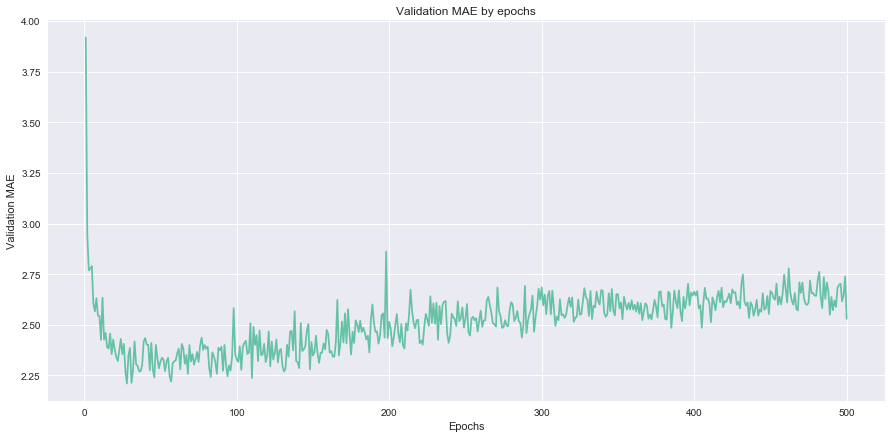

In [183]:
import matplotlib.pyplot as plt
# plot of mae history
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.title('Validation MAE by epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

This plot is difficult to see, so we have to clean it up a little but. We will leave out the first 10 points as they were on a very different scale than the rest of the curve. We will also replace each point with an exponential moving average of the previous point to smooth the curve [35](#35).

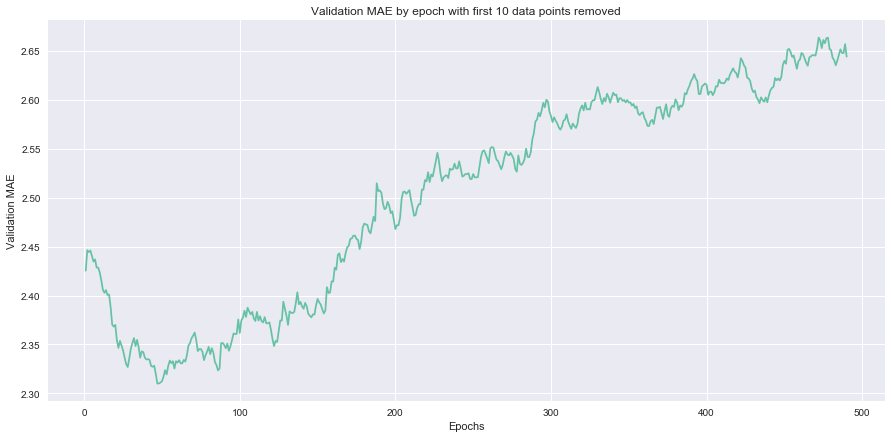

In [184]:
# [36]
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.title('Validation MAE by epoch with first 10 data points removed')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, the model stops improving after 50 epochs. Beyond this we are overfitting the model.

To train this model we can adjust other parameters like the number of epochs or the size of the hidden layers based on the observations we have made. Once we establish the best parameters to use, we can train a final model on all of the training data using these and then test its performance on our test data. After testing some different parameters, I think this gives the best results.

In [199]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=50, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)


100/100 [==============================] - 0s 730us/step


In [200]:
test_mae_score

2.5275020599365234

So the test_mae_score tells us that we are off in our predictions by approximately $2,528. This is not great considering the distribution of house prices in the set.

## Conclusion <a class="ancor" id="conclusion"/>

In examining this dataset and applying machine learning a couple of key points are apparent
- Mean squared error (MSE) is a loss function commonly used in regression.
- When evaluating regression, the concept of accuracy doesn't really apply like it would for example in classification. In this case it is common practice to use mean absolute error in this situation (MAE).
- When the features in the inputs have values in different ranges, each feature should be scaled independently in preprocessing the data.
- In a small dataset like this one, k-fold validation is a reliable way to evaluate a model.
- When training small datasets like this, it is better to use a small network with few hidden layers (usually 1 or 2) to avoid overfitting the model.
- Given the high variance on the prince range, I don't think this is a robust model and, therefore, not appropiate for making predictions...prehaps if we had more samples or columns? Also it probably isn't the best idea to estimate the price of an individual home based on the features of the neighbourhood alone. In the same neighbourhoods prices can vary massively.

## Refrences <a class="ancor" id="refs"/>

1. <a class="ancor" id="1"/></a>https://stackoverflow.com/questions/26873127/show-dataframe-as-table-in-ipython-notebook [Online] Accessed on: 9/12/2019
2. <a class="ancor" id="2"/></a>https://stackoverflow.com/questions/39047915/concat-series-onto-dataframe-with-column-name [Online] Accessed on: 9/12/2019
3. <a class="ancor" id="3"/></a>https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f [Online] Accessed on: 9/12/2019
4. <a class="ancor" id="4"/></a>https://erikrood.com/Python_References/replace_nan_zero_final.html [Online] Accessed on: 9/12/2019
5. <a class="ancor" id="5"/></a>https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html [Online] Accessed on: 9/12/2019
6. <a class="ancor" id="6"/></a>https://www.investopedia.com/terms/t/t-test.asp [Online] Accessed on: 9/12/2019
7. <a class="ancor" id="7"/></a>https://stats.stackexchange.com/questions/7845/best-way-to-put-two-histograms-on-same-scale [Online] Accessed on: 9/12/2019
8. <a class="ancor" id="8"/></a>https://medium.com/@rrfd/f-tests-and-anovas-examples-with-the-iris-dataset-fe7caa3e21d0 [Online] Accessed on: 9/12/2019
9. <a class="ancor" id="9"/></a>https://statistics.laerd.com/spss-tutorials/one-way-anova-using-spss-statistics.php [Online] Accessed on: 9/12/2019
10. <a class="ancor" id="10"/></a>https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html [Online] Accessed on: 9/12/2019
11. <a class="ancor" id="11"/></a>https://stackoverflow.com/questions/47068709/your-cpu-supports-instructions-that-this-tensorflow-binary-was-not-compiled-to-u [Online] Accessed on: 9/12/2019
12. <a class="ancor" id="12"/></a>https://docs.conda.io/projects/conda/en/4.6.0/_downloads/52a95608c49671267e40c689e0bc00ca/conda-cheatsheet.pdf [Online] Accessed on: 9/12/2019
13. <a class="ancor" id="13"/></a>https://stackoverflow.com/questions/57381430/synonym-of-type-is-deprecated-in-a-future-version-of-numpy-it-will-be-underst [Online] Accessed on: 9/12/2019
14. <a class="ancor" id="14"/></a>https://stackoverflow.com/questions/45035929/creating-new-pandas-dataframe-from-certain-columns-of-existing-dataframe [Online] Accessed on: 9/12/2019
15. <a class="ancor" id="15"/></a>https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html [Online] Accessed on: 9/12/2019
16. <a class="ancor" id="16"/></a>https://stackoverflow.com/questions/41808286/assert-two-variables-are-almost-equal-in-python [Online] Accessed on: 9/12/2019
17. <a class="ancor" id="17"/></a>https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/ [Online] Accessed on: 9/12/2019
18. <a class="ancor" id="18"/></a>https://docs.scipy.org/doc/numpy/reference/generated/numpy.isclose.html [Online] Accessed on: 9/12/2019
19. <a class="ancor" id="19"/></a>https://statisticsbyjim.com/regression/overfitting-regression-models/ [Online] Accessed on: 9/12/2019
20. <a class="ancor" id="20"/></a>https://www.statisticssolutions.com/multicollinearity/ [Online] Accessed on: 9/12/2019
21. <a class="ancor" id="21"/></a>https://www.investopedia.com/terms/v/variance-inflation-factor.asp [Online] Accessed on: 9/12/2019
22. <a class="ancor" id="22"/></a>https://etav.github.io/python/vif_factor_python.html [Online] Accessed on: 9/12/2019
23. <a class="ancor" id="23"/></a>https://www.researchgate.net/post/Multicollinearity_issues_is_a_value_less_than_10_acceptable_for_VIF [Online] Accessed on: 9/12/2019
24. <a class="ancor" id="24"/></a>https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLSResults.outlier_test.html [Online] Accessed on: 9/12/2019
25. <a class="ancor" id="25"/></a>Mastering Machine Learning with Python in Six Steps: A Practical Implementation Guide to Predictive Data Analytics Using Python by Manohar Swamynathan
26. <a class="ancor" id="26"/></a> https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02 [Online] Accessed on: 9/12/2019
27. <a class="ancor" id="27"/></a>https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02 [Online] Accessed on: 9/12/2019
28. <a class="ancor" id="28"/></a>https://sebastianraschka.com/Articles/2014_about_feature_scaling.html [Online] Accessed on: 9/12/2019
29. <a class="ancor" id="29"/></a>https://stats.stackexchange.com/questions/134104/why-do-we-divide-by-the-standard-deviation-and-not-some-other-standardizing-fact [Online] Accessed on: 9/12/2019
30. <a class="ancor" id="30"/></a>https://stackoverflow.com/questions/45834276/numpyzero-mean-data-and-standardization [Online] Accessed on: 9/12/2019
31. <a class="ancor" id="31"/></a>https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw [Online] Accessed on: 9/12/2019
32. <a class="ancor" id="32"/></a>https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0 [Online] Accessed on: 9/12/2019
33. <a class="ancor" id="33"/></a>https://medium.com/@ewuramaminka/mean-absolute-error-mae-machine-learning-ml-b9b4afc63077 [Online] Accessed on: 9/12/2019
34. <a class="ancor" id="34"/></a>https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6 [Online] Accessed on: 9/12/2019
35. <a class="ancor" id="35"/></a>https://machinelearningmastery.com/k-fold-cross-validation/ [Online] Accessed on: 9/12/2019
36. <a class="ancor" id="36"/></a>https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/ [Online] Accessed on: 9/12/2019
37. <a class="ancor" id="37"/></a>https://towardsdatascience.com/implementing-moving-averages-in-python-1ad28e636f9d [Online] Accessed on: 9/12/2019